# Industry Accelerators - Customer Segmentation Prediction Models 

## Introduction

In this notebook we will do some customer segmentation work. Segmentation can help you to identify and understand customer subgroups and how they differ from one another. Customer segmentation has many beneficial uses. In our case for example, it can be used to assign the best-fit agent, identify opportunities for leveraging agent skills, or even to create hosting opportunities to improve client engagement.<br><br>
We'll prepare the data so it's in a wide format ready for segmentation and then apply some transformation and clustering techniques. Our data contains demographic, behavioural, summary product and communication based data. Since there are currently no predefined segments we'll need to discover segments within the underlying data structure. Once that structure is found we'll assign clients to their respective clusters and surface that information through and user interface.

**Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2020. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
import sys
import joblib
import seaborn as sns

import time 
from project_lib import Project
project = Project()


from sklearn.preprocessing import StandardScaler


if '/project_data/data_asset/' not in sys.path:
    sys.path.insert(0, '/project_data/data_asset/')
    
from customer_segmentation_prep import *

%matplotlib inline

## Load Customer Segmentation Data

For this project we will be loading the csv file called **customer_full_summary_latest.csv**. The file is located in the `/project_data/data_asset/` directory. We use project-lib library to fetch and save the files associated with the project.

The easiest way to load in data is to use the <b>Find and Add Data</b> icon in the upper right hand corner. Once selected you will see a sidebar come out with options to load from either Files or Connections.

If you loaded your dataset into a Watson Studio analytics project, like a CSV file, then select Files and you should be able to find your dataset name. From there you can click the <b>Insert to code</b> and select to either insert a pandas dataframe or a spark dataframe. Once you make the selection you'll see python code inserted into the notebook cell with either Pandas or PySpark code for reading in your data. Now you're ready to explore and manipulate your dataset. 

## Plot Functions

Here is a plotting function with an example to view the distribution of any feature within the dataset.

In [2]:
# Plot function for feature distribution
def plot_chart(df, col_name, col_type=None):
    
    if col_type == None:
        if is_string_dtype(df[col_name]):
            col_type = 'string'
        elif is_numeric_dtype(df[col_name]):
            col_type = 'numeric'
        else:
            print('Pass col_type to function to specify if it is string or numeric')
        
    if col_type == 'string':
        ax = df[col_name].value_counts().plot(kind='bar')
        ax.set_ylabel('Count')
    elif col_type == 'numeric':
        # if there are less than 10 values in the numeric column we redefine it as a string so we plot a bar chart
        if df[col_name].nunique() <= 10:
            ax = df[col_name].value_counts().sort_index().plot(kind='bar')
        else:
            ax = df[col_name].plot.density()
            
        ax.get_xaxis().set_major_formatter(
            plt.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    else:
        print(' Re-run specifying the col_type')

    ax.set_xlabel(col_name)
    ax.set_title(col_name + ' Column Distribution')

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)


This function plots the distribution of categorical variables by each cluster.

In [3]:
def plot_categorical_vars(cat_var_for_plotting, prepped_data_pre_transform):
    df_temp = prepped_data_pre_transform.groupby(['CLUSTERS', cat_var_for_plotting]).size().reset_index()
    df_temp.rename(columns={0:'VALUES'}, inplace=True)
    df_temp = df_temp.pivot(index='CLUSTERS', columns=cat_var_for_plotting, values='VALUES').reset_index()
    df_temp
    
    ax = df_temp.set_index('CLUSTERS').plot(kind='bar', stacked=True, figsize=(12,7), title=cat_var_for_plotting + ' by Cluster')
    
    return

This function plots the distribution of numerical variables by each cluster.

In [4]:
def plot_numeric_vars(var, prepped_data_pre_transform, num_clusters):
    
    
    if len(prepped_data_pre_transform[var].unique()) > 2:
    
        plt.figure(figsize=(12,7))
        for cluster in range(0, num_clusters + 1):
            # Subset to the airline
            subset = prepped_data_pre_transform[prepped_data_pre_transform['CLUSTERS'] == cluster]
            try:
                # Draw the density plot
                sns.distplot(subset[var], hist = False, kde = True,
                             kde_kws = {'linewidth': 3},
                             label = 'cluster ' + str(cluster))

                plt.title('Density Plot for ' + var)    
            except:
                pass
    return

## User Inputs and Data Prep

### User Inputs
**effective_date :**  This is the date that the segmentation is computed. All input data should be before this date.<br>
**train_or_score :**  Specify whether we are prepping the data for training or scoring. Should always be 'train' in this notebook.<br>

**granularity_key :** Specifies the customer ID column.<br>
**customer_start_date :** Column with the start of the summary month of customer data.<br> 
**customer_end_date :** As above, but last day of the summary month.<br>
**status_attribute :** Column which indicates whether the customer is active or inactive and is used to define churn. Churned customers are removed from the dataset.<br>
**status_flag_active :** The name of the variable in the status_attribute that indicates that the customer has churned, in this case it is 'Inactive'.<br>
**date_customer_joined :** Specifies the column where the customer join date is recorded. This variable is used to calculate customer tenure.<br>

**columns_required :** A list of default columns required, includes ID column and date columns.<br>
**default_attributes :** A list of the variables that we would like to use for the segmentation.<br>
**risk_tolerance_list :** A list of the risk categories for the customer's accounts. 'High', 'Low' etc.<br> 
**investment_objective_list :** A list of the investment objective categories for the customer's accounts. 'Security', 'Income' etc.<br>

The last three user input variables are used for data cleaning.<br>
**std_multiplier :** This variable is used to identify outlier values. This number is multiplied by the variable standard deviation. Any value above this is defined as an outlier and the value is capped at this number multiplied by the standard deviation.<br>
**max_num_cat_cardinality :** This variable defines the maximum cardinality for categorical variables. Any categorical variable with more categories than this maximum is removed from the dataset.<br> 
**nulls_threshold :** This threshold is used to identify columns with many null values. Any column with percentage of nulls greater than this threshold will be removed from the dataset.<br>

The user can use the default inputs as listed below or can choose their own. The user inputs will be stored and the same inputs will be applied automatically at scoring time. 


### Data Prep
See `project_data/data_asset/customer_segmentation_prep.py` for details of data preparation.

The script generates the dataset that is used for clustering. We take a wide form dataset with customer details, filter to include only columns that are relevant, complete data cleaning and produce a dataframe suitable for clustering. 

### Data Cleaning
•	Any customer who attrited in the dataset is removed. Only active customers are used for clustering.<br>
•	We take the most recent record for each customer.<br>
•	Any columns in the dataset that have a single constant value are removed.<br>
•	Any column with more than 10% null values is removed.<br>
•	High cardinality categorical columns are removed.<br>
•	Numerical outliers are cleaned. <br>
•	Remaining missing values are filled with 'Unknown' for categorical and the average of the column for numerical. 

In [5]:
# User input variables
effective_date = '2018-09-30'  # date at which the prediction was computed 
train_or_score = 'train'

granularity_key='CUSTOMER_CUSTOMER_ID'
customer_start_date='CUSTOMER_SUMMARY_START_DATE'
customer_end_date='CUSTOMER_SUMMARY_END_DATE'
status_attribute='CUSTOMER_STATUS'
status_flag_active='Active'
date_customer_joined='CUSTOMER_RELATIONSHIP_START_DATE'

columns_required=['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_STATUS', 'CUSTOMER_SUMMARY_START_DATE', 'CUSTOMER_SUMMARY_END_DATE',
                    'CUSTOMER_EFFECTIVE_DATE',  'CUSTOMER_SYSTEM_LOAD_TIMESTAMP']

default_attributes=['CUSTOMER_GENDER', 'CUSTOMER_AGE_RANGE', 'CUSTOMER_EDUCATION_LEVEL',
                            'CUSTOMER_EMPLOYMENT_STATUS', 'CUSTOMER_MARITAL_STATUS', 
                            'CUSTOMER_URBAN_CODE', 'CUSTOMER_ANNUAL_INCOME', 'CUSTOMER_RELATIONSHIP_START_DATE', 
                            'CUSTOMER_SUMMARY_RETURN_LAST_QUARTER', 
                            'CUSTOMER_SUMMARY_NUMBER_OF_EMAILS',
                            'CUSTOMER_SUMMARY_NUMBER_OF_LOGINS',
                    'CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES',
                           'CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY', 'CUSTOMER_CREDIT_AUTHORITY_LEVEL', 'CUSTOMER_CUSTOMER_BEHAVIOR', 'CUSTOMER_IMPORTANCE_LEVEL_CODE',
                           'CUSTOMER_MARKET_GROUP',
                           'CUSTOMER_PURSUIT']
risk_tolerance_list = []
investment_objective_list = []

std_multiplier=5
max_num_cat_cardinality=15
nulls_threshold=0.1

In [6]:
customer_full_summary_latest_file = project.get_file("customer_full_summary_latest.csv")
customer_full_summary_latest_file.seek(0)

df_raw = pd.read_csv(customer_full_summary_latest_file,
                     parse_dates=['CUSTOMER_RELATIONSHIP_START_DATE',
                                 'CUSTOMER_SUMMARY_END_DATE', 'CUSTOMER_SUMMARY_START_DATE'], infer_datetime_format=True)

data_prep = CustomerSegmentationPrep(train_or_score=train_or_score, effective_date=effective_date, granularity_key=granularity_key, customer_start_date=customer_start_date, customer_end_date=customer_end_date,
                                        status_attribute=status_attribute, status_flag_active=status_flag_active, date_customer_joined=date_customer_joined, columns_required=columns_required, default_attributes=default_attributes,
                                        risk_tolerance_list=risk_tolerance_list, investment_objective_list=investment_objective_list, std_multiplier=std_multiplier, max_num_cat_cardinality=max_num_cat_cardinality, nulls_threshold=nulls_threshold)
df_prepped = data_prep.prep_data(df_raw, train_or_score)

Before removing inactive customers we have 1000 customers
After removing inactive customers we have 838 customers
Before cleaning, we had 22 columns.
After cleaning, we have 19 columns.
Add a column for customer tenure
Prepped data has 838 rows and 17 columns.
Prep has data for 838 customers


In [7]:
# Preview prepped data
df_prepped.head()

CUSTOMER_CUSTOMER_ID CUSTOMER_EFFECTIVE_DATE  \
0                  1000              2018-01-02   
1                  1001              2017-11-29   
2                  1002              2017-08-28   
3                  1003              2018-01-17   
4                  1004              2018-01-03   

  CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY CUSTOMER_AGE_RANGE  \
0                             Recreation           30 to 40   
1                          Uncategorized        65 and over   
2                                 Travel           55 to 65   
3                                 Travel        65 and over   
4                                   Food           40 to 55   

  CUSTOMER_CUSTOMER_BEHAVIOR CUSTOMER_GENDER CUSTOMER_MARKET_GROUP  \
0                   Moderate            Male          Accumulating   
1                 Aggressive          Female               Gifting   
2                     Growth          Female          Accumulating   
3                     Growth          Female          Accumulating   
4                   Moderate            Male          Accumulating   

  CUSTOMER_MARITAL_STATUS  CUSTOMER_ANNUAL_INCOME CUSTOMER_URBAN_CODE  \
0                 Married                325000.0                City   
1                Divorced                280000.0               Urban   
2                 Married                130000.0               Urban   
3                 Married                120000.0               Urban   
4                 Married                350000.0                City   

  CUSTOMER_EMPLOYMENT_STATUS     CUSTOMER_PURSUIT  \
0                   Employed  Capital Acquisition   
1               Selfemployed  Retirement Planning   
2                  Homemaker   Increase Net Worth   
3                  Homemaker   Increase Net Worth   
4                   Employed      Estate Planning   

  CUSTOMER_IMPORTANCE_LEVEL_CODE  CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES  \
0                   Low priority                                     1757.13   
1                Normal priority                                    17935.79   
2                  High priority                                     1221.06   
3                  High priority                                     1176.59   
4                   Low priority                                    14452.36   

  CUSTOMER_EDUCATION_LEVEL CUSTOMER_CREDIT_AUTHORITY_LEVEL  \
0                  College                          Medium   
1             Professional                       Very High   
2                      PhD                        Very Low   
3                      PhD                        Very Low   
4                  College                          Medium   

   CUSTOMER_TENURE_IN_MONTHS  
0                          8  
1                         10  
2                         13  
3                          8  
4                          8

Now that the data is prepared we need to continue with a few more data preparation steps before we can do clustering. First is to simply remove the columns `CUSTOMER_CUSTOMER_ID` and `CUSTOMER_EFFECTIVE_DATE` since they're not needed for segmentation.

In [8]:
# Drop columns not needed for segmentation
df_prepped.drop(['CUSTOMER_CUSTOMER_ID', 'CUSTOMER_EFFECTIVE_DATE'], axis=1, inplace=True)

### Dummy Variables

Next, since our data contains mixed data types, categorical and numeric, we need to convert those categorical features to numeric by creating binary dummy variables. Once we create the dummy variables from the categorical features we'll drop the original categorical features.

In [9]:
# Create lists of the numeric and categorical features
numeric_cols = list(df_prepped.select_dtypes(include=[np.number]).columns)
categorical_cols = list(df_prepped.select_dtypes(include=[object]).columns)

# Copy of the prepped dataframe before any transformations are carried out
prepped_data_pre_transform = df_prepped.copy()

# Create dummy variables for categorical features and drop original
for col in categorical_cols:
    df_prepped = pd.concat([df_prepped, pd.get_dummies(df_prepped[col], prefix=col, drop_first=True)], axis=1)
    df_prepped.drop(col, axis=1, inplace=True)

### Standardize Data

The last step for our data preparation is to standardize the numeric variables. Standardizing numeric values prior to clustering is common practice especially when dealing with features of varying scales (number of children vs summary of assets amount). This helps to improve the cluster quality as well as cluster algorithm accuracy and performance.

In [10]:
scale_features = df_prepped[numeric_cols]

scaler = StandardScaler()
scale_features = scaler.fit_transform(scale_features.values)
df_prepped[numeric_cols] = scale_features

# store the columns to be standardised, means and standard deviations in the training metadata 
with open('/project_data/data_asset/training_data_metadata.json', 'r') as f:
    training_metadata = json.load(f)

training_metadata['cols_to_standardise'] = numeric_cols
training_metadata['scaler_means'] = list(scaler.mean_)
training_metadata['scaler_standard_dev'] = list(np.sqrt(scaler.var_))

# store the names of the columns used for training
training_metadata['cols_used_for_training'] = list(df_prepped.columns)

with open('/project_data/data_asset/training_data_metadata.json', 'w') as f:
    json.dump(training_metadata, f)

In [11]:
# Preview prepped data with standardized numeric values
df_prepped.head()

CUSTOMER_ANNUAL_INCOME  CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES  \
0                0.932255                                   -0.850833   
1                0.573600                                    2.167705   
2               -0.621916                                   -0.950851   
3               -0.701617                                   -0.959148   
4                1.131508                                    1.517783   

   CUSTOMER_TENURE_IN_MONTHS  CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Giving  \
0                  -0.897529                                              0   
1                  -0.701125                                              0   
2                  -0.406519                                              0   
3                  -0.897529                                              0   
4                  -0.897529                                              0   

   CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Health  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Housing  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Insurance  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Personal  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Recreation  \
0                                                  1   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY_Savings  ...  \
0                                               0  ...   
1                                               0  ...   
2                                               0  ...   
3                                               0  ...   
4                                               0  ...   

   CUSTOMER_IMPORTANCE_LEVEL_CODE_Low priority  \
0                                            1   
1                                            0   
2                                            0   
3                                            0   
4                                            1   

   CUSTOMER_IMPORTANCE_LEVEL_CODE_Normal priority  \
0                                               0   
1                                               1   
2                                               0   
3                                               0   
4                                               0   

   CUSTOMER_EDUCATION_LEVEL_High School  CUSTOMER_EDUCATION_LEVEL_PhD  \
0                                     0                             0   
1                                     0                             0   
2                                     0                             1   
3                                     0                             1   
4                                     0                             0   

   CUSTOMER_EDUCATION_LEVEL_Professional  CUSTOMER_EDUCA

## Principal Component Analysis (PCA)

Now that our data is clean with some transformations we're going to do one last transformation. We'll use principal components analysis (PCA) to reduce the dimensionality of our data and reduce clustering computation. Also, performing PCA prior to clustering can often help with performance if there are underlying linear relationships with the data. This isn't always the case and is dependent on your data, but it did hold true with our customer dataset.

Below we perform PCA on our dataset and select 14 components. You can see the newly transformed and reduced data set below. This will be the data set that we pass to our clustering algorithm.

In [12]:
# PCA
pca = PCA(n_components=14)
df_pca = pca.fit_transform(df_prepped)

# Preview transformed data
pd.DataFrame(df_pca).head()

0         1         2         3         4         5         6  \
0 -1.633069  0.313649 -0.425015  0.899856 -0.658679  1.346527  0.145229   
1  2.412770  1.449158 -1.563411  0.826072 -0.414705 -0.496579  0.013736   
2  0.275778 -0.993911  1.886191  0.385648  0.002758  0.249280  0.753729   
3  0.530588 -1.085195  1.672390  0.855310 -0.271361  0.266466  0.280996   
4 -0.680556  1.766475 -1.074686  1.096721  1.025808  0.680416 -0.147254   

          7         8         9        10        11        12        13  
0  0.203848 -0.128834 -0.038208  0.131275  0.130880 -0.073826 -0.263315  
1  0.963513 -0.196755  0.225272 -0.689175 -0.154723  0.175143  0.049410  
2  0.430149  0.490033  0.696685 -0.194747 -0.642833 -0.127884 -0.247735  
3 -0.008652  0.419015  0.739323 -0.531998 -0.802103 -0.160165 -0.663449  
4 -0.195455  0.256239  0.172345 -0.220302  0.447037  0.011090  0.351826

From our PCA, we can view how much variance is explained for each additional principal component. The below cumulative sum shows that the first 14 components explains 90.6% of the data.

In [13]:
# Percent variance explained array
print(np.cumsum(pca.explained_variance_ratio_))

[0.21764406 0.38447951 0.52871062 0.64044143 0.70645547 0.74986159
 0.78734266 0.81547564 0.83739013 0.85529121 0.87230688 0.88615573
 0.89701605 0.90684323]


Below we save our PCA model for later scoring.

In [14]:
# Save out PCA
# mimetype is guessed when promoting the asset into the deployment space
# we need to save the file as a type recognised by the mimetype library
# this doesn't impact the object type
joblib.dump(pca, '/project_data/data_asset/pca.txt')

['/project_data/data_asset/pca.txt']

## K-means Clustering

We can now begin clustering. For clustering we'll use the k-means clustering algorithm. K-means clustering simply partitions the data into k clusters where each observation or client belongs to the cluster with the nearest mean. When using k-means you have to specify the number of clusters beforehand, but often times that number is unknown. We'll loop through the k-means algorithm using a range of number of clusters and determine cluster number by using the metric called silhouette coefficient. The silhouette coefficient indicates how similar the observations within its own cluster are compared to other observations in different clusters. Range for silhouette coefficient are from -1 to 1 where 1 represents objects within its own cluster are well paired.

In [15]:
# Specify max number of clusters for iteration
max_number_of_clusters = 15

# Loop through K-means and view silhouette coefficient to determine number of clusters
for i in range(2, max_number_of_clusters+1):
    kmeans_mdl = KMeans(n_clusters=i, random_state=1234)
    #kmeans_mdl.fit(df_pca)
    kmeans_mdl.fit(df_prepped)
    labels = kmeans_mdl.labels_
    silhouette_coef = metrics.silhouette_score(df_pca, labels, metric='euclidean')
    print('Silhouette coefficient for ' + str(i) + ' clusters:' + str(silhouette_coef))

Silhouette coefficient for 2 clusters:0.22430917410999182
Silhouette coefficient for 3 clusters:0.23195653177195147
Silhouette coefficient for 4 clusters:0.27508904574573045
Silhouette coefficient for 5 clusters:0.2864078114326003
Silhouette coefficient for 6 clusters:0.2788840543721505
Silhouette coefficient for 7 clusters:0.29420324170741036
Silhouette coefficient for 8 clusters:0.2839047968547276
Silhouette coefficient for 9 clusters:0.26649225577359237
Silhouette coefficient for 10 clusters:0.2635484181111457
Silhouette coefficient for 11 clusters:0.2677632941001278
Silhouette coefficient for 12 clusters:0.25489493215563136
Silhouette coefficient for 13 clusters:0.2598362319559942
Silhouette coefficient for 14 clusters:0.25942601345440974
Silhouette coefficient for 15 clusters:0.24574591250118483


For the above exercise we see that number of clusters should be 6 or 7 based on the silhouette coefficient. For this exercise we selected 7 clusters.

We then fit the k-means algorithm to our data using the specified 7 clusters. Then we add those cluster assignments back to the PCA dataframe so we can visualize the cluster assignments on a 2-dimensional plot.

In [16]:
# K-means with 7 clusters based on silhouette coefficient
num_clusters = 7
kmeans_mdl = KMeans(n_clusters=num_clusters, random_state=1234)
pc_clusters = kmeans_mdl.fit_predict(df_pca)

In [17]:
# Create dataframe with PCA and cluster assignments
# increment the cluster number by 1 so that cluster numbers start at 1 instead of 0
df_pca_clusters = pd.DataFrame(df_pca, columns=['pc_1','pc_2','pc_3','pc_4','pc_5','pc_6','pc_7','pc_8','pc_9','pc_10','pc_11','pc_12','pc_13','pc_14'])
df_pca_clusters['cluster_id'] = pc_clusters + 1
df_pca_clusters.head()

pc_1      pc_2      pc_3      pc_4      pc_5      pc_6      pc_7  \
0 -1.633069  0.313649 -0.425015  0.899856 -0.658679  1.346527  0.145229   
1  2.412770  1.449158 -1.563411  0.826072 -0.414705 -0.496579  0.013736   
2  0.275778 -0.993911  1.886191  0.385648  0.002758  0.249280  0.753729   
3  0.530588 -1.085195  1.672390  0.855310 -0.271361  0.266466  0.280996   
4 -0.680556  1.766475 -1.074686  1.096721  1.025808  0.680416 -0.147254   

       pc_8      pc_9     pc_10     pc_11     pc_12     pc_13     pc_14  \
0  0.203848 -0.128834 -0.038208  0.131275  0.130880 -0.073826 -0.263315   
1  0.963513 -0.196755  0.225272 -0.689175 -0.154723  0.175143  0.049410   
2  0.430149  0.490033  0.696685 -0.194747 -0.642833 -0.127884 -0.247735   
3 -0.008652  0.419015  0.739323 -0.531998 -0.802103 -0.160165 -0.663449   
4 -0.195455  0.256239  0.172345 -0.220302  0.447037  0.011090  0.351826   

   cluster_id  
0           6  
1           1  
2           5  
3           5  
4           7

## Visualize Clusters

To see the visual representation of our newly assigned clusters we plot, on a 2-dimensional plot, the 1st principal component with the 2nd principal component as the x and y-axis. Then we set the `cluster_id` as the color so we can better visualize the cluster assignments or segments. You can see from below that we have some nice exclusiveness with our clusters even on the 2-dimensional space.

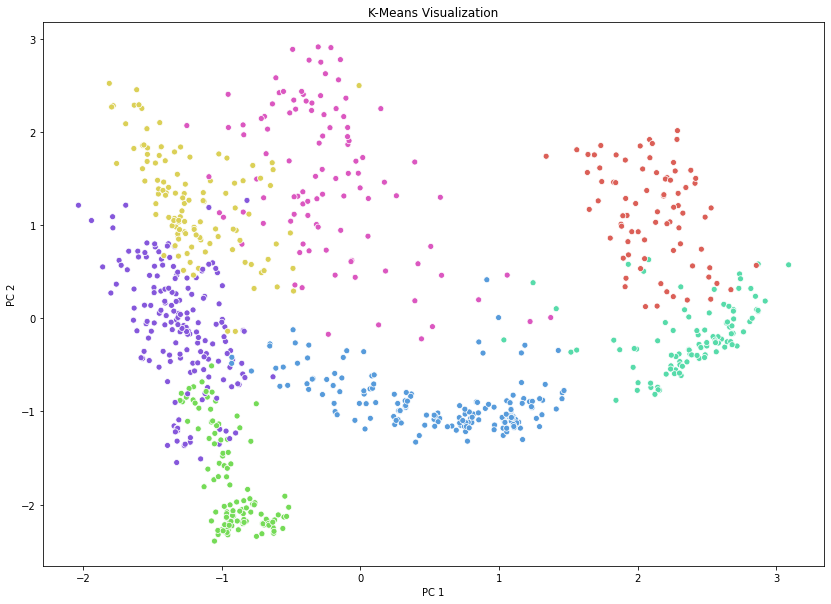

In [18]:
# Plot k-means results with cluster assignments
plt.figure(figsize=(14,10))

ax = sns.scatterplot(
    x="pc_1",
    y="pc_2",
    data=df_pca_clusters,
    hue="cluster_id",
    legend=False,
    palette=sns.color_palette("hls", num_clusters)
)

ax.set(xlabel="PC 1", ylabel="PC 2", title="K-Means Visualization");

### Save the model to Cloud Pak for Data

In the next steps we save and deploy the kmeans model.

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.

The steps involved in saving and deploying the model are detailed in the following cells.  We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.

Before we save the model, we append the clusters to the original prepped dataframe, before we scaled and created dummy variables. We save this dataframe out so that it can be used in the R Shiny dashboard.

In [19]:
prepped_data_pre_transform['CLUSTERS'] = kmeans_mdl.labels_
# increment cluster numbers by 1 so we start at 1 instead of 0
prepped_data_pre_transform['CLUSTERS'] = prepped_data_pre_transform['CLUSTERS'] + 1

# save data for dynamic dashboard
project.save_data("cluster_df.csv", prepped_data_pre_transform.to_csv(index=False), overwrite=True)

prepped_data_pre_transform.head()

CUSTOMER_SUMMARY_TOP_SPENDING_CATEGORY CUSTOMER_AGE_RANGE  \
0                             Recreation           30 to 40   
1                          Uncategorized        65 and over   
2                                 Travel           55 to 65   
3                                 Travel        65 and over   
4                                   Food           40 to 55   

  CUSTOMER_CUSTOMER_BEHAVIOR CUSTOMER_GENDER CUSTOMER_MARKET_GROUP  \
0                   Moderate            Male          Accumulating   
1                 Aggressive          Female               Gifting   
2                     Growth          Female          Accumulating   
3                     Growth          Female          Accumulating   
4                   Moderate            Male          Accumulating   

  CUSTOMER_MARITAL_STATUS  CUSTOMER_ANNUAL_INCOME CUSTOMER_URBAN_CODE  \
0                 Married                325000.0                City   
1                Divorced                280000.0               Urban   
2                 Married                130000.0               Urban   
3                 Married                120000.0               Urban   
4                 Married                350000.0                City   

  CUSTOMER_EMPLOYMENT_STATUS     CUSTOMER_PURSUIT  \
0                   Employed  Capital Acquisition   
1               Selfemployed  Retirement Planning   
2                  Homemaker   Increase Net Worth   
3                  Homemaker   Increase Net Worth   
4                   Employed      Estate Planning   

  CUSTOMER_IMPORTANCE_LEVEL_CODE  CUSTOMER_SUMMARY_AMOUNT_OF_MANAGEMENT_FEES  \
0                   Low priority                                     1757.13   
1                Normal priority                                    17935.79   
2                  High priority                                     1221.06   
3                  High priority                                     1176.59   
4                   Low priority                                    14452.36   

  CUSTOMER_EDUCATION_LEVEL CUSTOMER_CREDIT_AUTHORITY_LEVEL  \
0                  College                          Medium   
1             Professional                       Very High   
2                      PhD                        Very Low   
3                      PhD                        Very Low   
4                  College                          Medium   

   CUSTOMER_TENURE_IN_MONTHS  CLUSTERS  
0                          8         6  
1                         10         1  
2                         13         5  
3                          8         5  
4                          8         7

### User Inputs
The user can specify the name for the space, model and model deployment.  <br>
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to `True`.

In [27]:
# Specify a name for the space being created, the saved models and the model deployments
space_name = 'Customer Segmentation Space'
model_name = 'customer_segmentation_model'
deployment_name = 'customer_segmentation_model_deployment'

use_existing_space=True

Below code imports `ibm-watson-machine-learning` library and then creates a wml client using the credentials provided.

In [21]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "3.5"
}

client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space. Use the name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space. If a space with specified space_name already exists, the existing space will be used to store and deploy models and functions by default. If a new space needs to be created by replacing the exisiting one with the same name, the user accordingly will need to set the **use_exisiting_space** parameter as False as mentioned earlier. 

In [28]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with ",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(10)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)

Deployment space with  Customer Segmentation Space already exists . .
Using the existing space


### Store the Model Details

Store the model in the deployment space. Again, the name for the model is specified in the user inputs cell above. Software specification and default tag for the model are specified in the model metadata. <br>
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `default_py3.7` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 

In [23]:
sw_spec_uid = client.software_specifications.get_uid_by_name("default_py3.7")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.23",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid,
    client.repository.ModelMetaNames.TAGS: ['customer_segmentation_model_tag']
}

stored_model_details = client.repository.store_model(model=kmeans_mdl, meta_props=metadata)
stored_model_details

{'entity': {'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd',
   'name': 'default_py3.7'},
  'type': 'scikit-learn_0.23'},
 'metadata': {'created_at': '2020-11-16T12:38:14.936Z',
  'id': '60bce0ea-ad8f-4f7b-8f9e-416dd9e77c5b',
  'modified_at': '2020-11-16T12:38:15.775Z',
  'name': 'customer_segmentation_model',
  'owner': '1000331001',
  'space_id': '16fca047-d59d-40cf-ad33-fabff20b740c',
  'tags': ['customer_segmentation_model_tag']},
 'system': {'warnings': []}}

### Deploy the Model 

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 

In [24]:
# deploy the model
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : ['customer_segmentation_deployment_tag'],
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

model_uid = stored_model_details["metadata"]["id"]
client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: '60bce0ea-ad8f-4f7b-8f9e-416dd9e77c5b' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e144f8fb-5b7f-4740-97e2-4c84ef2a8514'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': '60bce0ea-ad8f-4f7b-8f9e-416dd9e77c5b'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'Not_Applicable', 'name': 'S', 'num_nodes': 1},
  'name': 'customer_segmentation_model_deployment',
  'online': {},
  'space_id': '16fca047-d59d-40cf-ad33-fabff20b740c',
  'status': {'online_url': {'url': 'https://internal-nginx-svc:12443/ml/v4/deployments/e144f8fb-5b7f-4740-97e2-4c84ef2a8514/predictions'},
   'state': 'ready'}},
 'metadata': {'created_at': '2020-11-16T12:38:16.491Z',
  'id': 'e144f8fb-5b7f-4740-97e2-4c84ef2a8514',
  'modified_at': '2020-11-16T12:38:16.491Z',
  'name': 'customer_segmentation_model_deployment',
  'owner': '1000331001',
  'space_id': '16fca047-d59d-40cf-ad33-fabff20b740c',
  'tags': ['customer_segmentation_deployment_tag']}}

## Plot Variable Distribution by Cluster

The below code loops through each categorical variable and plots the distribution of each variable by cluster, followed by doing the same for numerical variables. 

Taking the example of Cluster 7, we see that the majority of customers are homemakers or retired. Their primary pursuit is increasing net worth and they exhibit aggressive customer behaviour. All of the customers in this cluster are female, 55 or over, highly educated and urban living. Their annual income is mid-range while they are on the higher end for the amount they pay in fees.

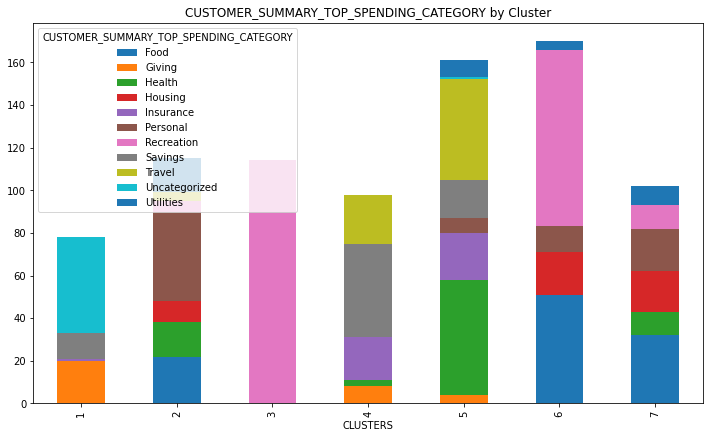

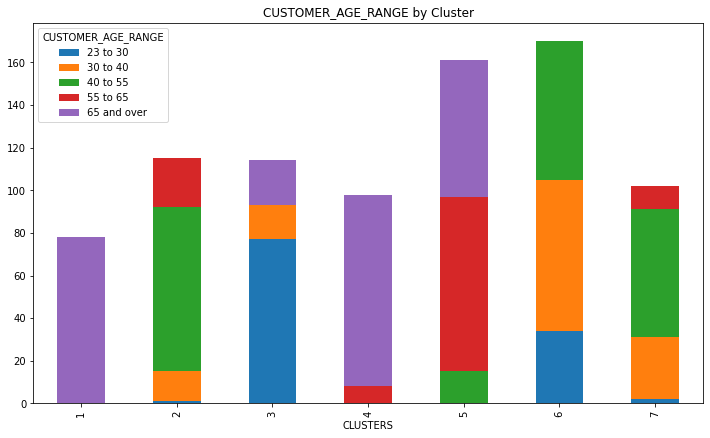

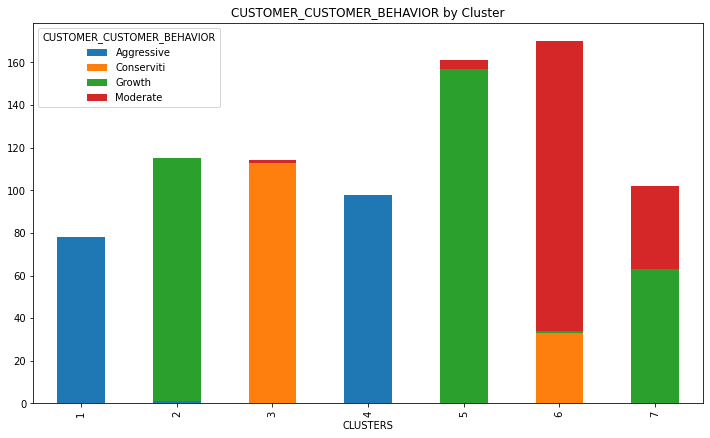

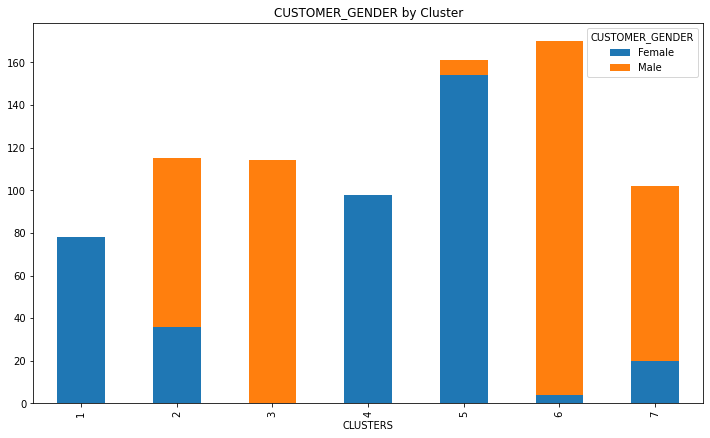

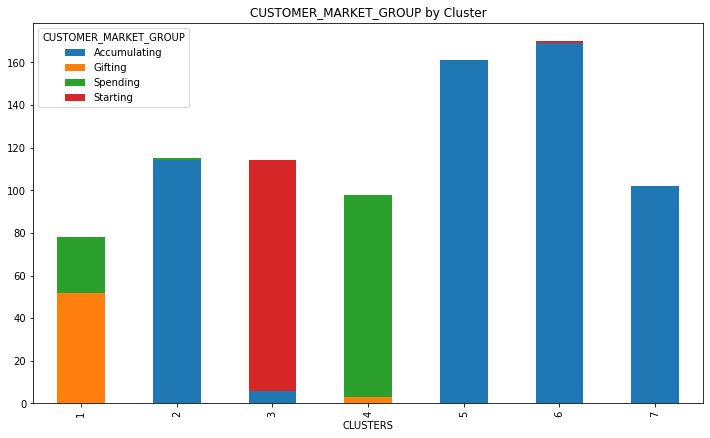

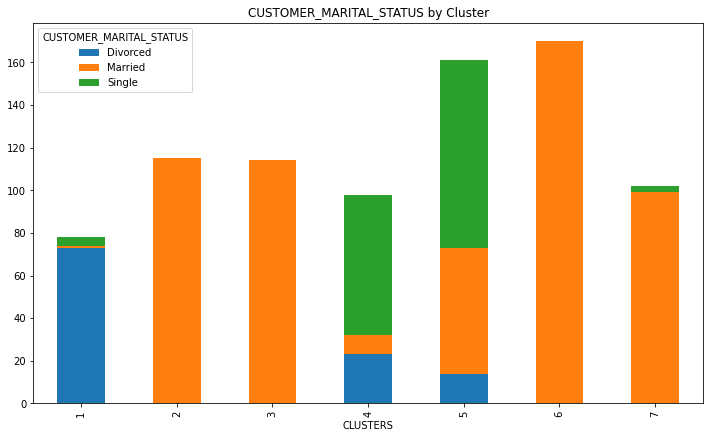

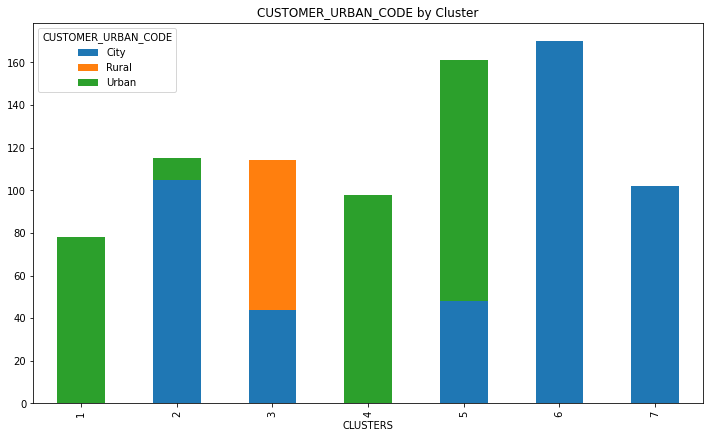

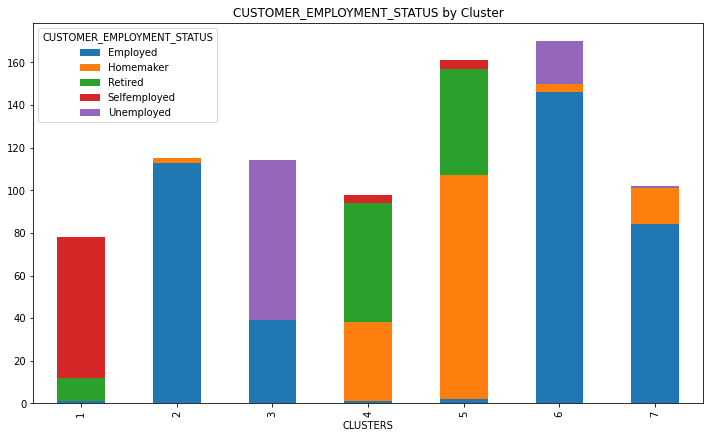

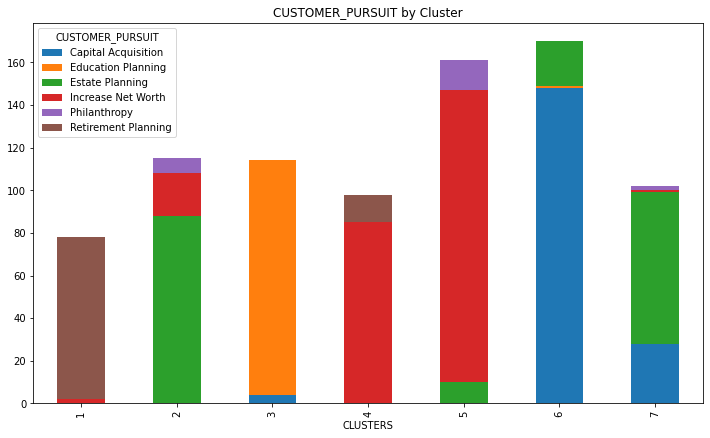

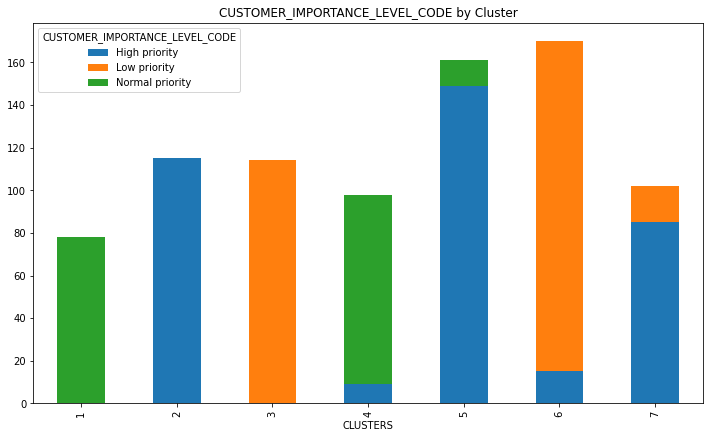

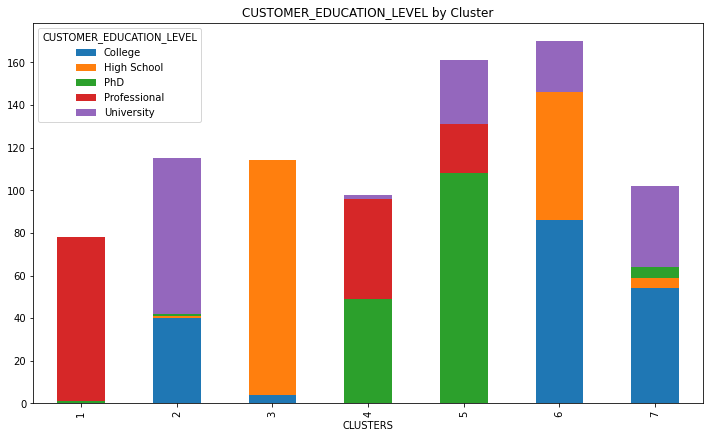

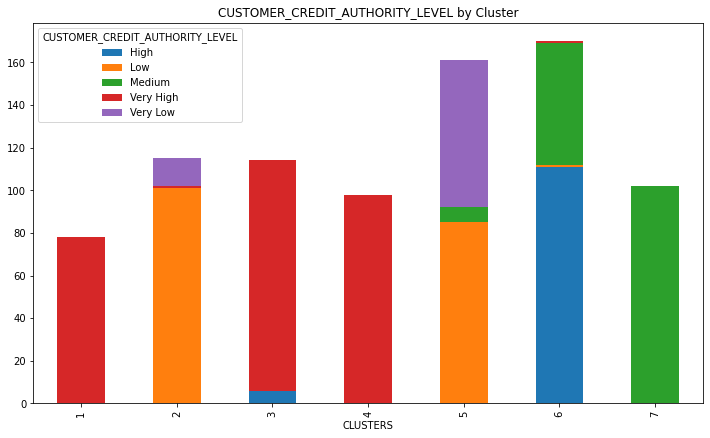

In [25]:
for var in categorical_cols:

    plot_categorical_vars(var, prepped_data_pre_transform)

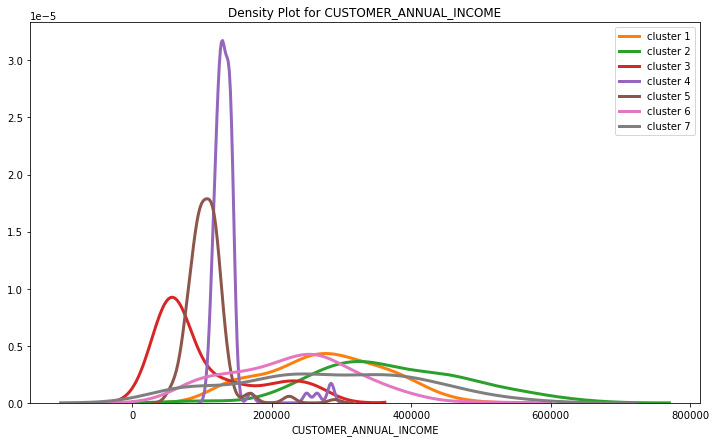

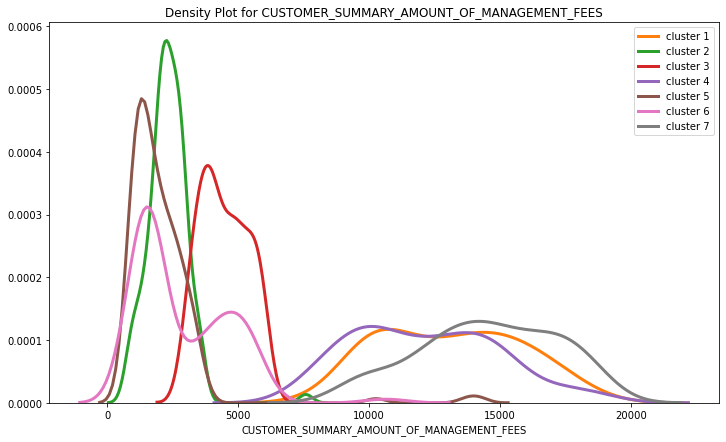

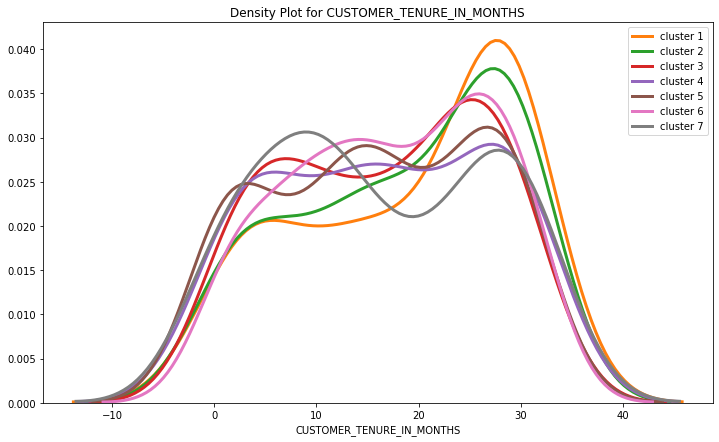

In [26]:
for col in numeric_cols:
    plot_numeric_vars(col, prepped_data_pre_transform, num_clusters)

### Operationalize the models

Now we are ready to operationalize our best model. See notebook **`2-model-scoring_and_app_deployment`** for the next step.